<a href="https://colab.research.google.com/github/moey920/NLP/blob/master/Seq2Seq%2BAttention_mechanism_for_reciept_OCR_error_fix2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1) 데이터 로드하기

In [4]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_csv("/content/drive/My Drive/캐시카우_노하람인턴_공유폴더/seq2seq/임시/seq2seq_dataset_수정5.csv", nrows = 100000)
print('전체 리뷰 개수 :',(len(data)))

전체 리뷰 개수 : 5392


In [5]:
data.head()

,전,후,인덱스
0,CJ올리브영( ㈜ 이선신보집,CJ올리브영㈜ 인천신포점,1
1,인전광역시 중구 개항로 32 - 1,인천광역시 중구 개항로 32-1,2
2,5298501337 김희선 TEL : 032 - 765 - 5290,5298501337 김희선 TEL:032-765-5290,3
3,2020 -04 -26 19 : 39 :03 POS : 1001- 00161 김희선,2020-04-26 19:39:03 POS:1001-00161 김희선,4
4,고객센터 : 1577 - 4887 www .oliveyoung . co . kr,고객센터 : 1577-4887 www.oliveyoung.co.kr,5


In [6]:
data = data[['전','후']]
data.head()

,전,후
0,CJ올리브영( ㈜ 이선신보집,CJ올리브영㈜ 인천신포점
1,인전광역시 중구 개항로 32 - 1,인천광역시 중구 개항로 32-1
2,5298501337 김희선 TEL : 032 - 765 - 5290,5298501337 김희선 TEL:032-765-5290
3,2020 -04 -26 19 : 39 :03 POS : 1001- 00161 김희선,2020-04-26 19:39:03 POS:1001-00161 김희선
4,고객센터 : 1577 - 4887 www .oliveyoung . co . kr,고객센터 : 1577-4887 www.oliveyoung.co.kr


In [7]:
# 랜덤으로 10개의 샘플 출력
data.sample(10)

,전,후
1810,"[ 적립/잔여포인트] 390/1,296","[적립/잔여포인트] 390/1,296"
4274,정상] 2020- 04 -08 15: 30 : 46 POS : 01 (평택푸),[정상] 2020-04-08 15:30:46 POS:01 (평택푸)
2753,NO:655226 담당 자:04850 [신세계영등포제일 *,NO:655226 담당자:04850[신세계영등포제일*
5375,부가세 110.212,"부 가 세: 10,212"
387,"E R )망고오렌지 스무 | 0 5 ,700","E R)망고오렌지 스무 1 0 5,700"
2758,"( 단, 식품 단순변심 교환/환불 불가)","(단,식품 단순변심 교환/환불 불가)"
4154,Ittp. www.seowil.cON TEL : 055 - 356 - 5535,http://www.seowon.com TEL:055-356-5535
146,할부개월: 00 승인번호: 472802555,할부개월: 00 승인번호: 47280255
1007,[ 쿠폰번호 920003**,[ 쿠폰번호 ] 920003**
4108,다음달(1일) 소멸예정포인트 :,다음달(1일) 소멸예정포인트:


# 2) 데이터 정제하기

In [9]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['전'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['후'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 4917
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 4101


In [0]:
# '전' 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['전'], inplace=True)

In [13]:
print(data.isnull().sum())

전    0
후    0
dtype: int64


In [12]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 4916


원본의 최소 길이 : 1
원본의 최대 길이 : 40
원본의 평균 길이 : 5.132017900732302
수정본의 최소 길이 : 1
수정본의 최대 길이 : 11
수정본의 평균 길이 : 3.3854759967453214


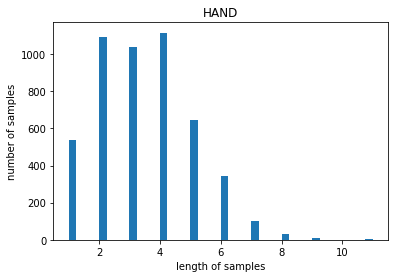

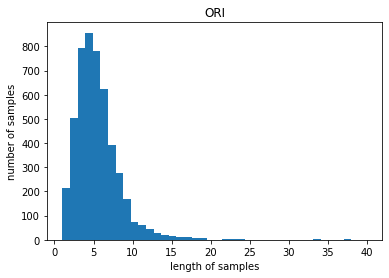

In [17]:
# 길이 분포 출력
ori_len = [len(s.split()) for s in data['전']]
hand_len = [len(s.split()) for s in data['후']]

print('원본의 최소 길이 : {}'.format(np.min(ori_len)))
print('원본의 최대 길이 : {}'.format(np.max(ori_len)))
print('원본의 평균 길이 : {}'.format(np.mean(ori_len)))
print('수정본의 최소 길이 : {}'.format(np.min(hand_len)))
print('수정본의 최대 길이 : {}'.format(np.max(hand_len)))
print('수정본의 평균 길이 : {}'.format(np.mean(hand_len)))

plt.title('HAND')
plt.hist(hand_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('ORI')
plt.hist(ori_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [0]:
# 데이터를 분석한 결과를 토대로 패딩의 길이 정하기. 평균 길이보다 약간 크게 잡아주겠습니다.
ori_max_len = 20
hand_max_len = 10

In [0]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(ori_max_len, data['전'])

전체 샘플 중 길이가 20 이하인 샘플의 비율: 0.9961350691619203


In [22]:
below_threshold_len(hand_max_len, data['후'])

전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.999593165174939


In [23]:
# 정해준 최대 길이보다 큰 샘플들은 제거하겠습니다.
data = data[data['전'].apply(lambda x: len(x.split()) <= ori_max_len)]
data = data[data['후'].apply(lambda x: len(x.split()) <= hand_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 4895


In [24]:
data.head()

,전,후
0,CJ올리브영( ㈜ 이선신보집,CJ올리브영㈜ 인천신포점
1,인전광역시 중구 개항로 32 - 1,인천광역시 중구 개항로 32-1
2,5298501337 김희선 TEL : 032 - 765 - 5290,5298501337 김희선 TEL:032-765-5290
3,2020 -04 -26 19 : 39 :03 POS : 1001- 00161 김희선,2020-04-26 19:39:03 POS:1001-00161 김희선
4,고객센터 : 1577 - 4887 www .oliveyoung . co . kr,고객센터 : 1577-4887 www.oliveyoung.co.kr


In [0]:
# seq2seq 훈련을 위해서는 디코더의 예측 대상에 시작 토큰과 종료 토큰을 추가할 필요가 있습니다. 
# 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 명명하고 앞, 뒤로 추가하겠습니다.

In [25]:
# hand 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['후'] = data['후'].apply(lambda x : 'sostoken '+ x + ' eostoken')
data.head()

,전,후
0,CJ올리브영( ㈜ 이선신보집,sostoken CJ올리브영㈜ 인천신포점 eostoken
1,인전광역시 중구 개항로 32 - 1,sostoken 인천광역시 중구 개항로 32-1 eostoken
2,5298501337 김희선 TEL : 032 - 765 - 5290,sostoken 5298501337 김희선 TEL:032-765-5290 eostoken
3,2020 -04 -26 19 : 39 :03 POS : 1001- 00161 김희선,sostoken 2020-04-26 19:39:03 POS:1001-00161 김희...
4,고객센터 : 1577 - 4887 www .oliveyoung . co . kr,sostoken 고객센터 : 1577-4887 www.oliveyoung.co.kr...


In [0]:
# 이를 각각 Text_data와 Summary_data로 저장하겠습니다.
ori_data = list(data['전'])
hand_data = list(data['후'])

# 3) 데이터의 분리

In [39]:
# 훈련 데이터와 테스트 데이터를 분리해봅시다. 데이터가 워낙 적어서 검증=테스트 라고 생각해주시면 되겠습니다.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ori_data, hand_data, test_size=0.2, random_state=0, shuffle=True)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 3916
훈련 레이블의 개수 : 3916
테스트 데이터의 개수 : 979
테스트 레이블의 개수 : 979


# 4) 정수 인코딩

In [0]:
'''이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 
훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다. 우선, 원문에 해당되는 X_train에 대해서 수행합니다.'''
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 src_tokenizer.word_index에 저장되어져 있습니다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [41]:
threshold = 2
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 5443
등장 빈도가 1번 이하인 희귀 단어의 수: 4020
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1423
단어 집합에서 희귀 단어의 비율: 73.85632923020393
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 24.00143292136844


등장 빈도가 threshold 값인 2회 미만. 즉, 1회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 24.39%입니다. 다른 데이터에서는 2~3% 정도일텐데 영수증 OCR 원시 데이터의 특수성이 드러나는 부분입니다. 전체 단어에서 24%의 영향이나 배제해버리는건 무리가 있겠다 싶지만, 원본 데이터가 워낙 노이즈가 많으니 24%의 쓰레기라고 생각하고 배제하도록 하곘습니다.

전체 크기와 비슷한 값으로 단어 집합의 크기를 1400으로 제한하겠습니다

In [0]:
src_vocab = 1400
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(X_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
X_train = src_tokenizer.texts_to_sequences(X_train) 
X_test = src_tokenizer.texts_to_sequences(X_test)

In [43]:
# 정수 인코딩이 정상 진행되었는지 훈련 데이터에 대해서 5개의 샘플을 출력해봅시다.
print(X_train[:5])

[[8], [7, 3, 59, 1, 3, 59], [236], [81, 1, 1], [21, 237]]


In [0]:
# 이제 레이블에 해당하는 정답(hand) 데이터에 대해서도 수행하겠습니다.

In [0]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

In [46]:
threshold = 2
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4394
등장 빈도가 1번 이하인 희귀 단어의 수: 2943
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1451
단어 집합에서 희귀 단어의 비율: 66.97769685935367
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.872201379644197


In [0]:
tar_vocab = 1400
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train) 
y_test = tar_tokenizer.texts_to_sequences(y_test) 

In [48]:
print(y_train[:5])

[[1, 90, 11, 2], [1, 9, 4, 56, 3, 4, 56, 2], [1, 939, 439, 284, 2], [1, 58, 940, 3, 2], [1, 40, 41, 156, 94, 2]]


# 5) 빈 샘플(empty samples) 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었다는 것을 의미합니다. 길이가 0이 된 샘플들의 인덱스를 받아옵시다. 주의할 점은 요약문에는 sostoken과 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하여 단어 집합 제한에도 삭제 되지 않습니다. 그래서 이제 길이가 0이 된 정답문의 실질적 길이는 2입니다.

In [0]:
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

In [52]:
'''훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 2인 경우의 인덱스를 각각 drop_train과 drop_test에 저장하였습니다. 삭제 전의 훈련 데이터와 테스트 데이터의 개수를 출력해봅시다.'''

'훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 2인 경우의 인덱스를 각각 drop_train과 drop_test에 저장하였습니다. 삭제 전의 훈련 데이터와 테스트 데이터의 개수를 출력해봅시다.'

In [55]:
# # 삭제 전의 개수는 다음과 같습니다.
print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 3709
훈련 레이블의 개수 : 3709
테스트 데이터의 개수 : 901
테스트 레이블의 개수 : 901


In [54]:
# 삭제 후의 개수는 다음과 같습니다.
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 3709
훈련 레이블의 개수 : 3709
테스트 데이터의 개수 : 901
테스트 레이블의 개수 : 901


# 6) 패딩하기

In [0]:
# 훈련 데이터와 테스트 데이터에 대해서 패딩 작업을 수행합니다. 이미 앞서 정해둔 최대 길이를 넘는 샘플들은 제외했기 때문에 따로 길이 분포를 재확인하지는 않겠습니다.
X_train = pad_sequences(X_train, maxlen = ori_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = ori_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = hand_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = hand_max_len, padding='post')

# 3. seq2seq + attention으로 요약 모델 설계 및 훈련시키기

In [0]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 인코더를 설계해보겠습니다. 
인코더는 LSTM 층을 3개 쌓습니다.

In [59]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(ori_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## 디코더를 설계해보겠습니다. 
단, 출력층은 제외하고 설계하겠습니다. 디코더의 설계는 인코더와 사실상 동일하지만 초기 상태(initial_state)를 인코더의 상태로 주어야 하는 것에 주의합시다.

In [60]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb = Embedding(tar_vocab, embedding_dim)(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

이번 챕터에서는 어텐션 메커니즘을 사용할 예정이므로 위에서 기존에 seq2seq에서 설계한 출력층을 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층을 설계해보겠습니다. 어텐션 함수를 직접 작성하지 않고 이미 깃허브에 공개된 함수를 사용할 것이므로 아래의 코드를 통해 attention.py 파일을 다운로드하고, AttentionLayer를 임포트합니다.

In [0]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

## 어텐션 메커니즘
을 이용해 디코더의 출력층을 새롭게 설계합니다.

In [62]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 128)      179200      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 20, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
# 총 3,047,032개의 파라미터를 가진 모델이 설계됩니다. 이제 모델을 컴파일합니다.
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [0]:
# 조기 종료 조건을 설정하고 모델을 학습시킵니다. 인자들에 자세한 설명은 seq2seq로 영수증 맞춤법 해결하기.ipynb를 보시면 기록되어있습니다.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                  epochs=50, callbacks=[es], batch_size = 256, validation_data=([X_test, y_test[:,:-1]],
                  y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))